In [2]:
# import os; os.environ['KERAS_BACKEND'] = 'tensorflow'
# import plaidml.keras
# plaidml.keras.install_backend()
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
batch_size = 1000

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        )

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Get the labels for our training data into a pandas 'dataframe' object (the generator below needs this)
train_labels = pandas.read_csv('train.csv')

In [7]:
train_generator = train_datagen.flow_from_dataframe(
        train_labels,           # dataframe containing our train data labels
        'data/train/',          # this is the target directory
        x_col = 'Image',
        y_col = 'Id',
        target_size=(150, 150),
        batch_size=batch_size)

Found 20130 images belonging to 5005 classes.


In [8]:
validation_generator = test_datagen.flow_from_dataframe(
        train_labels,           # dataframe containing our train data labels
        'data/validation/',          # this is the target directory
        x_col = 'Image',
        y_col = 'Id',
        target_size=(150, 150),
        batch_size=batch_size)

Found 5231 images belonging to 5005 classes.


In [11]:
# Build up the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5005, activation='softmax'))
# model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1, right=1
  ret = ax.set_xlim(*args, **kwargs)


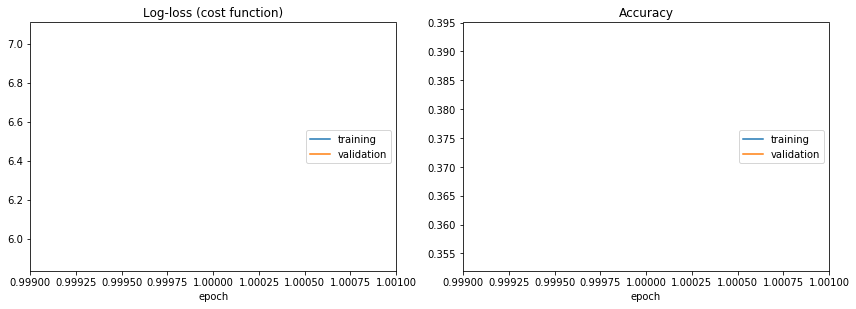

Log-loss (cost function):
training   (min:    7.051, max:    7.051, cur:    7.051)
validation (min:    5.893, max:    5.893, cur:    5.893)

Accuracy:
training   (min:    0.354, max:    0.354, cur:    0.354)
validation (min:    0.393, max:    0.393, cur:    0.393)


In [12]:
model.fit_generator(
        train_generator,
        steps_per_epoch=20130 // batch_size,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=5231 // batch_size,
        callbacks=[PlotLossesKeras()],
        )

In [13]:
# Here and below we do some prediction testing for diagnostic purposes
x,y = train_generator.next()

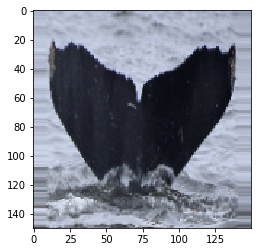

In [14]:
image = x[0]
plt.imshow(image)
plt.show()

In [15]:
xp = x[0].reshape(1, 150, 150, 3)

predictions = model.predict(xp)

In [16]:
print(x.shape)
print(predictions.shape)
print(predictions)

(1000, 150, 150, 3)
(1, 5005)
[[5.0315622e-04 7.8630306e-05 2.7908295e-04 ... 8.0782629e-05
  7.2760507e-05 2.3079685e-04]]


In [17]:
high_conf_results = [r for r in predictions[0] if r > 0.002]
print(high_conf_results)

[0.06809794, 0.002288581, 0.0024933396, 0.002387746, 0.0023058231, 0.0026384098, 0.002033949, 0.003192808, 0.002151284, 0.0020616795, 0.0027138232]


In [22]:
# Now we actually predict on the test set
test_generator = test_datagen.flow_from_directory(
        'data/test/',           # target directory
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,
        )

Found 7960 images belonging to 1 classes.


In [29]:
test_preds = model.predict_generator(test_generator, steps=1, use_multiprocessing=True)

In [42]:
# So this just finds the highest sureness in the prediction array, not the actual label predicted (which we would get from the *location* in the array. So I guess we need to do some matlab-style AND-ing or indexing or something. What we want is to unravel the matrix (also why is this a matrix?) and then take the index with the highest sureness/activation, and then lookup the location in the corresponding label list (which we'll have to build up) to find the label. Is there a cleaner way of doing this?)
pred = [max(x) for x in test_preds]
actual_pred = max(pred)

0.8779077